In [333]:
from tensorflow.keras.datasets import mnist

In [334]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [335]:
# load and data preprocessing
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train shape: ', str(x_train.shape))
print('y_train shape: ', str(y_train.shape))

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)


In [336]:
# declare kernels
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=np.float32)

diag_dr = np.array([
    [ 0, -1, -2],
    [ 1,  0, -1],
    [ 2,  1,  0]
], dtype=np.float32)

diag_dl = np.array([
    [-2, -1,  0],
    [-1,  0,  1],
    [ 0,  1,  2]
], dtype=np.float32)

laplacian = np.array([
    [ 0, -1,  0],
    [-1,  4, -1],
    [ 0, -1,  0]
], dtype=np.float32)

kernels = np.array([sobel_x, sobel_y, diag_dr, diag_dl, laplacian])

In [337]:
# define 2d convolution algorithm
def conv2d_baseline(image, kernel, padding=0, stride=1):
    # change to float32
    image = image.astype(np.float32)
    kernel = kernel.astype(np.float32)
    
    # find shape of image and kernel
    x_img, y_img = image.shape
    x_kern, y_kern = kernel.shape

    # find shape of output
    x_out = ((x_img - x_kern + 2 * padding) // stride) + 1
    y_out = ((y_img - y_kern + 2 * padding) // stride) + 1
    output = np.zeros((x_out, y_out), dtype=np.float32)

    # pad original image
    image_pad = np.pad(image, pad_width=padding, mode='constant', constant_values=0)
    
    # iterate through image
    for x in range(x_out):
        for y in range(y_out):
            x_start = x * stride
            y_start = y * stride

            # extract patch
            patch = image_pad[x_start:x_start + x_kern, y_start:y_start + y_kern]

            # compute element-wise multiplication
            output[x, y] = np.sum(patch * kernel) 
                
    return output

In [338]:
# define 2d convolution algorithm using matrix multiplication
#   for multiple kernels
def conv2d_matrix(image, kernels, padding=0, stride=1):
    # change to float32
    image = image.astype(np.float32)
    kernels = kernels.astype(np.float32)
    
    # find shape of image and kernel
    x_img, y_img = image.shape
    n_kern, x_kern, y_kern = kernels.shape

    # find shape of output
    x_out = ((x_img - x_kern + 2 * padding) // stride) + 1
    y_out = ((y_img - y_kern + 2 * padding) // stride) + 1
    output = np.zeros((x_out, y_out), dtype=np.float32)

    # pad original image
    image_pad = np.pad(image, pad_width=padding, mode='constant', constant_values=0)
    
    # create im2col matrix
    im2col_matrix = np.zeros((x_kern * y_kern, x_out * y_out), dtype=np.float32)

    # iterate through image
    col_index = 0
    for x in range(x_out):
        for y in range (y_out): 
            x_start = x * stride
            y_start = y * stride
            
            # extract patch
            patch = image_pad[x_start:x_start + x_kern, y_start:y_start + y_kern] # find area windowed by kernel 

            # flatten patch into im2col matrix
            im2col_matrix[:, col_index] = patch.flatten()
            col_index += 1

    # flatten kernel
    kernel_flat = [k.flatten() for k in kernels]

    # matrix multiplication
    output = kernel_flat @ im2col_matrix

    # print("kernels shape", kernels.shape)
    # print("im2col shape", im2col_matrix.shape, im2col_matrix)
    # print("output shape", output.shape, output)

    return output

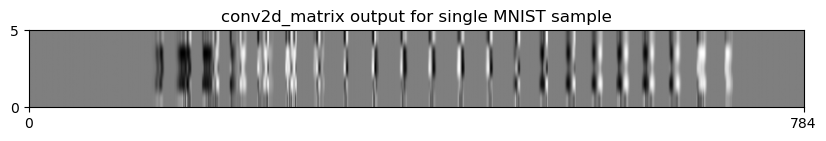

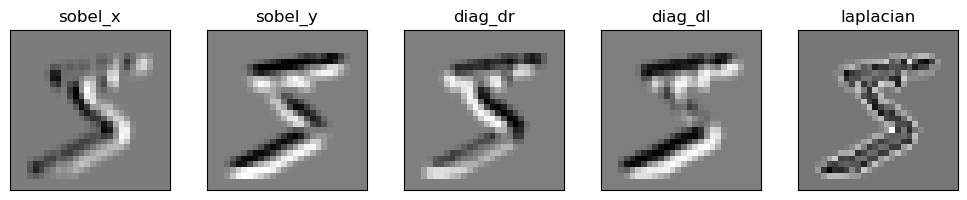

In [339]:
# conv2d_matrix tests

input = x_train[0]
out_matrix = conv2d_matrix(input, kernel_matrix, 1, 1)

fig = plt.figure(figsize=(10, 1))
plt.imshow(out_matrix, cmap='gray_r', aspect='auto', extent=[0, out_matrix.shape[1], 0, out_matrix.shape[0]])
plt.title("conv2d_matrix output for single MNIST sample")
plt.xticks([0, out_matrix.shape[1]])
plt.yticks([0, out_matrix.shape[0]])
plt.show()

feature_maps = list(out_matrix)
for i in range(len(feature_maps)):
    feature_maps[i] = feature_maps[i].reshape(28, 28)

kernel_labels = ['sobel_x', 'sobel_y', 'diag_dr', 'diag_dl', 'laplacian']
num_row = 1
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))
for i in range(len(feature_maps)):
    ax = axes[i]
    ax.imshow(feature_maps[i], cmap='gray_r')
    ax.set_title(kernel_labels[i])
    ax.set_xticks([])
    ax.set_yticks([])

# fig.suptitle("conv2d_matrix on mnisk sample") 
plt.tight_layout()
plt.show()

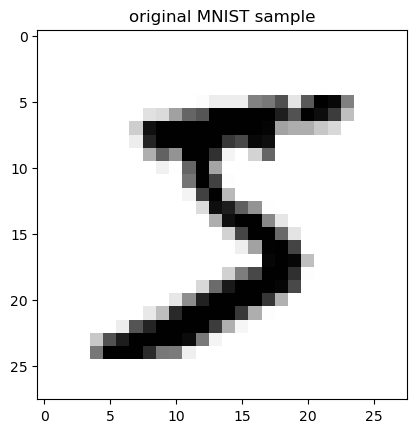

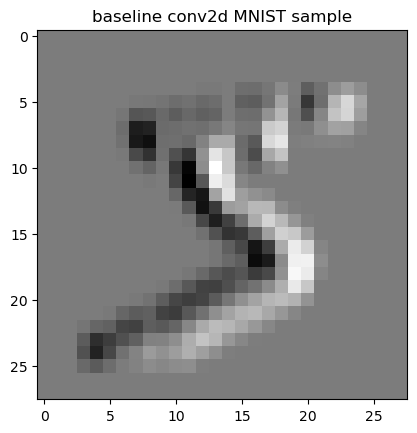

In [340]:
# conv2d_baseline tests

# input = x_train[0][12:16, 12:16]
input = x_train[0]

fig = plt.figure
plt.imshow(input, cmap='gray_r')
plt.title("original MNIST sample")
plt.show()

out_baseline = conv2d_baseline(input, sobel_x, 1, 1)
fig = plt.figure
plt.imshow(out_baseline, cmap='gray_r')
plt.title("baseline conv2d MNIST sample")
plt.show()

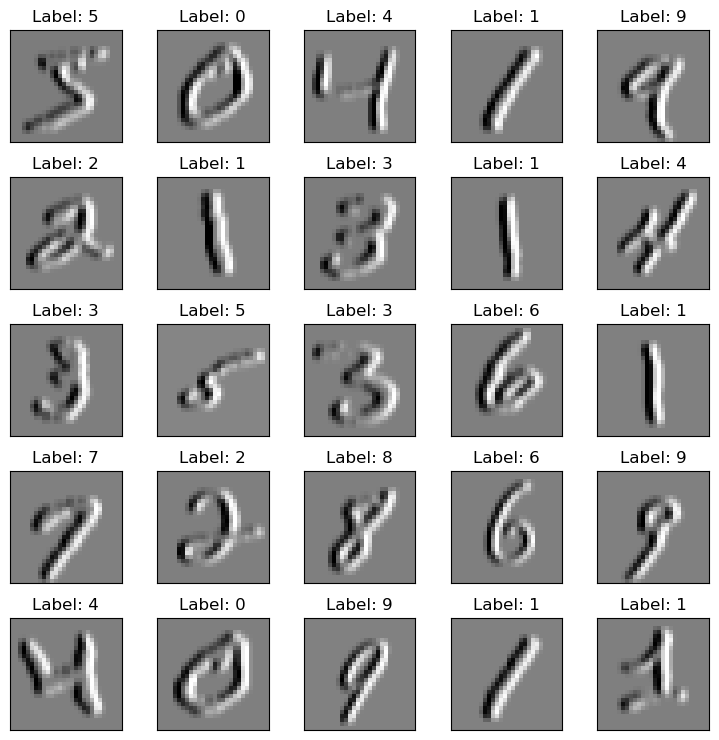

In [343]:
# conv2d_matrix test on multiple samples
num = 25
images = x_train[:num]
labels = y_train[:num]

num_row = 5
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 1.5*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    conv_out = conv2d_baseline(images[i], sobel_x, padding, stride)
    ax.imshow(conv_out, cmap='gray_r')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()